# Imports

In [365]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

torch.manual_seed()
sns.set()
%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv')

# Visualization of data

В данном датасете прдставлены изображения образцов рукописного написания цифр письменности индийского языка каннада.

Как и в международном варианте цифр в письменности каннада - десять: от 0 до 9. Из-за чего данный датасет можно воспринемать как обычный MNIST.

In [3]:
print('data shape ', data.shape)
print('data image size', np.sqrt(data.shape[1]-1))

data shape  (60000, 785)
data image size 28.0


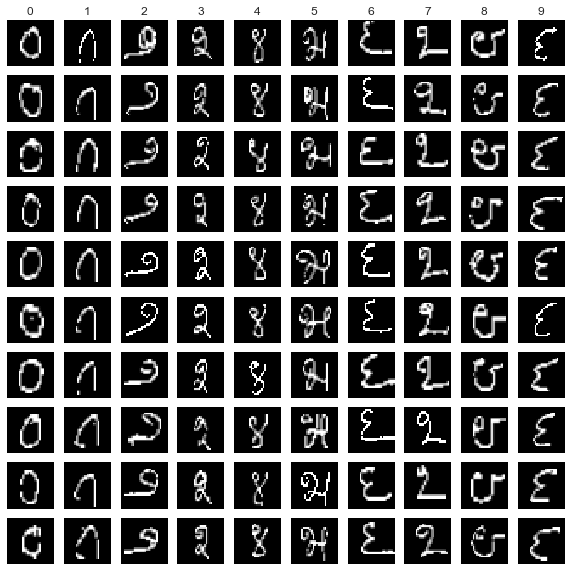

In [4]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

for i in range(10):
    random_num = np.random.randint(0, 100)
    num_i = data.drop('label', axis=1)[data['label'] == i]
    ax[0][i].set_title(i)
    for j in range(10): 
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j+random_num, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

# Dense autoencoder
Создадим простой энкодер, состоящий из небольшого количества Dense слоев.

На выходе энкодера и декодера используем сигмоиду как функцию активации, чтобы получить данные в формате [0, 1], чтобы при умножении на 255, их можно было визуализировать.

Так же протестируем различные варианты размерности нашего Latent Space слоя, чтобы определить минимальную размерность слоя, без резкой потери качества. 

In [415]:
class Autoencoder(nn.Module):
   
    def __init__(self, latent_size = 16):
        super(Autoencoder, self).__init__()
        self.latent_size = latent_size
        
        self.lin1 = nn.Linear(784, 300)
        self.lin2 = nn.Linear(300, self.latent_size)
        self.lin3 = nn.Linear(self.latent_size, 300)
        self.lin4 = nn.Linear(300, 784)
    
    def encoder(self, x):
        h1 = F.relu(self.lin1(x))
        h2 = F.sigmoid(self.lin2(h1))
        return h2
    
    def decoder(self, x):
        h3 = F.relu(self.lin3(x))
        h4 = F.sigmoid(self.lin4(h3))  
        return h4
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [423]:
def train(latent_size, BATCH_SIZE=32, N_EPOCHS=5, lr=0.001):
    device = torch.device('cuda:0')
    model = Autoencoder(latent_size).to(device)
    
    X = data.drop('label', axis=1).astype('float32') / 255.
    y = data['label']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.18, 
                                                      random_state=15)

    tensor_train = TensorDataset(torch.Tensor(X_train.to_numpy()), 
                                 torch.Tensor(np.array(y_train)))
    tensor_valid = TensorDataset(torch.Tensor(X_val.to_numpy()), 
                                 torch.Tensor(np.array(y_val)))

    train_loader = DataLoader(tensor_train, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(tensor_valid, batch_size=BATCH_SIZE, shuffle=True)
    

    optimizer = optim.Adam(model.parameters(), lr=lr)
#     optimizer = optim.RMSprop(model.parameters(), lr=lr)
    loss_function = nn.BCELoss().cuda(device)

    train_losses = []
    test_losses = []

    for epoch in range(N_EPOCHS):
        train_loss = 0
        val_loss = 0

        for X, _ in train_loader:
            model.train()
            optimizer.zero_grad()
            X = X.to(device)
            output = model(X).to(device)

            loss = loss_function(output, X)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        with torch.no_grad():
            for X_valid, _ in valid_loader:
                    model.eval()
                    X_valid = X_valid.to(device)
                    val_output = model(X_valid).to(device)
                    val_loss += loss_function(val_output, X_valid).item()

        model.train()
        train_loss = (train_loss / len(train_loader)) * 1000
        val_loss = (val_loss / len(valid_loader)) * 1000

        train_losses.append(train_loss)
        test_losses.append(val_loss)
        
        clear_output()
        plt.plot(train_losses, c='orange', label='train')
        plt.plot(test_losses, c='black', label='validation')
        plt.scatter(list(range(epoch+1)), train_losses, c='orange', s=16, alpha=0.5)
        plt.scatter(list(range(epoch+1)), test_losses, c='black', s=16, alpha=0.5)
        plt.title('Train/test scores by epoch, latent size is {}'.format(latent_size), fontsize=15)
        plt.xlabel('Epoch', fontsize=13)
        plt.ylabel('Score', fontsize=13)
        plt.legend()
        plt.show()
        for i in range(epoch+1):
            print('epoch: {}   score: {} | val score: {}'.format(
                i, np.round(train_losses[i], 2), 
                np.round(test_losses[i], 2)))
    return(model)

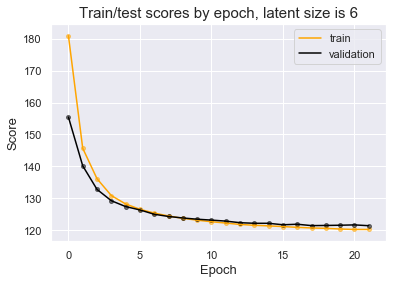

epoch: 0   score: 180.93 | val score: 155.44
epoch: 1   score: 145.68 | val score: 140.18
epoch: 2   score: 136.12 | val score: 132.79
epoch: 3   score: 130.86 | val score: 129.25
epoch: 4   score: 128.23 | val score: 127.42
epoch: 5   score: 126.56 | val score: 126.36
epoch: 6   score: 125.37 | val score: 125.01
epoch: 7   score: 124.46 | val score: 124.31
epoch: 8   score: 123.73 | val score: 123.84
epoch: 9   score: 123.15 | val score: 123.46
epoch: 10   score: 122.66 | val score: 123.17
epoch: 11   score: 122.25 | val score: 122.86
epoch: 12   score: 121.82 | val score: 122.36
epoch: 13   score: 121.54 | val score: 122.18
epoch: 14   score: 121.37 | val score: 122.17
epoch: 15   score: 121.15 | val score: 121.71
epoch: 16   score: 120.91 | val score: 121.88
epoch: 17   score: 120.71 | val score: 121.45
epoch: 18   score: 120.6 | val score: 121.5
epoch: 19   score: 120.38 | val score: 121.57
epoch: 20   score: 120.25 | val score: 121.67
epoch: 21   score: 120.26 | val score: 121.42


In [432]:
model_6 = train(6, 32, 22, 0.0045) # model_6, 32, 10, 0.003

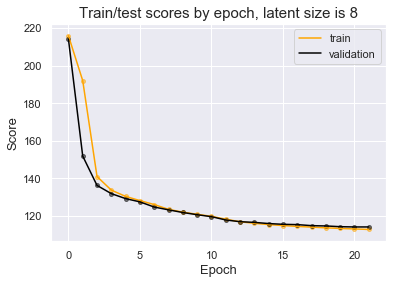

epoch: 0   score: 215.96 | val score: 214.18
epoch: 1   score: 192.07 | val score: 151.94
epoch: 2   score: 141.04 | val score: 136.32
epoch: 3   score: 133.81 | val score: 131.95
epoch: 4   score: 130.47 | val score: 129.3
epoch: 5   score: 128.24 | val score: 127.56
epoch: 6   score: 126.13 | val score: 124.81
epoch: 7   score: 123.59 | val score: 123.32
epoch: 8   score: 122.08 | val score: 121.92
epoch: 9   score: 120.95 | val score: 120.73
epoch: 10   score: 119.88 | val score: 119.69
epoch: 11   score: 118.33 | val score: 117.94
epoch: 12   score: 116.98 | val score: 117.02
epoch: 13   score: 116.16 | val score: 116.66
epoch: 14   score: 115.48 | val score: 116.03
epoch: 15   score: 114.96 | val score: 115.63
epoch: 16   score: 114.52 | val score: 115.47
epoch: 17   score: 114.14 | val score: 114.92
epoch: 18   score: 113.75 | val score: 114.76
epoch: 19   score: 113.43 | val score: 114.37
epoch: 20   score: 113.16 | val score: 114.22
epoch: 21   score: 112.89 | val score: 114.23

In [426]:
model_8 = train(8, 32, 22, 0.002) # model_6, 32, 10, 0.003

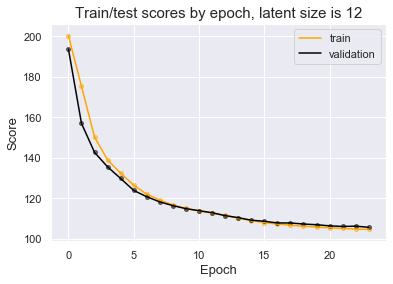

epoch: 0   score: 200.25 | val score: 193.67
epoch: 1   score: 175.32 | val score: 156.97
epoch: 2   score: 150.24 | val score: 142.66
epoch: 3   score: 138.92 | val score: 135.49
epoch: 4   score: 132.41 | val score: 129.78
epoch: 5   score: 126.42 | val score: 123.88
epoch: 6   score: 122.0 | val score: 120.76
epoch: 7   score: 119.12 | val score: 118.2
epoch: 8   score: 116.65 | val score: 116.38
epoch: 9   score: 115.0 | val score: 114.87
epoch: 10   score: 113.74 | val score: 113.89
epoch: 11   score: 112.68 | val score: 112.88
epoch: 12   score: 111.52 | val score: 111.45
epoch: 13   score: 110.17 | val score: 110.44
epoch: 14   score: 108.94 | val score: 109.18
epoch: 15   score: 108.01 | val score: 108.66
epoch: 16   score: 107.29 | val score: 107.82
epoch: 17   score: 106.72 | val score: 107.82
epoch: 18   score: 106.2 | val score: 107.29
epoch: 19   score: 105.82 | val score: 106.95
epoch: 20   score: 105.46 | val score: 106.39
epoch: 21   score: 105.12 | val score: 106.1
epo

In [442]:
model_12 = train(12, 32, 24, 0.0019)

### Визулизируем модели
Визулизируем исходные данные, полученные слои признаков и выходыные данные
#### Lanent space = 4

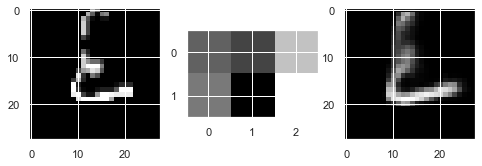

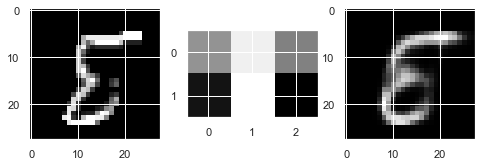

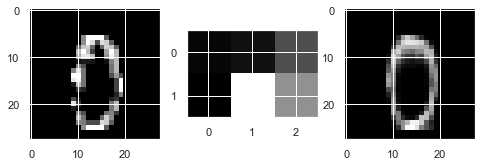

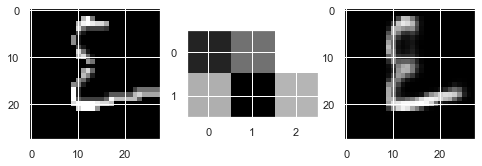

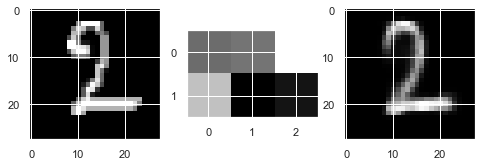

In [440]:
for i in range(30, 35):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((tensor_train.tensors[0][i].cpu().detach().numpy()*255).reshape(28, 28), cmap='gray')
    ax[1].imshow((model_6.encoder(tensor_train.tensors[0][i].cuda()).cpu().detach().numpy()*255).reshape((2, 3)), cmap='gray')
    ax[2].imshow((model_6.forward(tensor_train.tensors[0][i].cuda()).cpu().detach().numpy()*255).reshape(28, 28), cmap='gray')
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.show()

#### Lanent space = 6

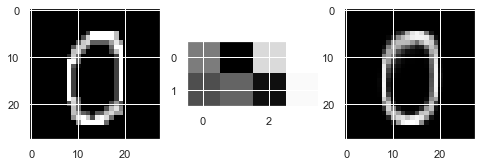

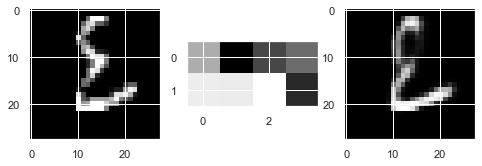

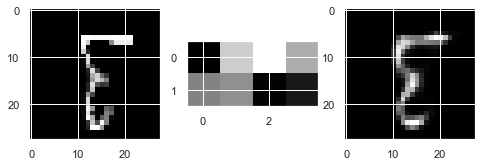

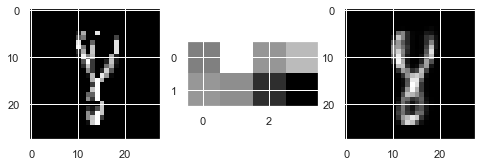

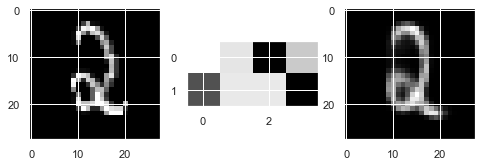

In [439]:
for i in range(35, 40):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((tensor_train.tensors[0][i].cpu().detach().numpy()*255).reshape(28, 28), cmap='gray')
    ax[1].imshow((model_8.encoder(tensor_train.tensors[0][i].cuda()).cpu().detach().numpy()*255).reshape((2, 4)), cmap='gray')
    ax[2].imshow((model_8.forward(tensor_train.tensors[0][i].cuda()).cpu().detach().numpy()*255).reshape(28, 28), cmap='gray')
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.show()

#### Lanent space = 12

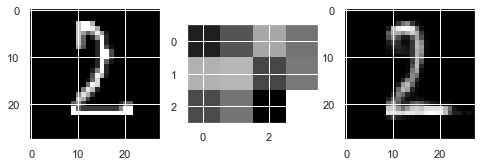

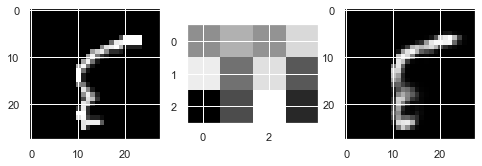

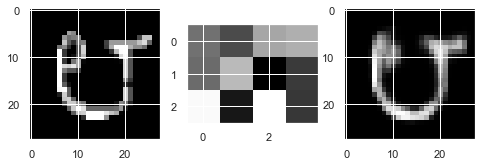

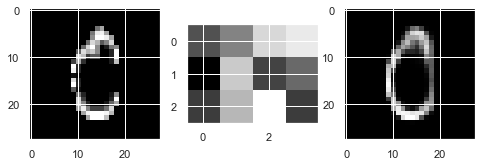

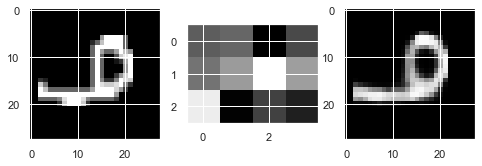

In [448]:
for i in range(160, 165):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((tensor_train.tensors[0][i].cpu().detach().numpy()*255).reshape(28, 28), cmap='gray')
    ax[1].imshow((model_12.encoder(tensor_train.tensors[0][i].cuda()).cpu().detach().numpy()*255).reshape((3, 4)), cmap='gray')
    ax[2].imshow((model_12.forward(tensor_train.tensors[0][i].cuda()).cpu().detach().numpy()*255).reshape(28, 28), cmap='gray')
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.show()

# Convolutional autoencoder  
Создадим более сложный энкодер с использованием сверточных слоев.

In [464]:
class AutoencoderConv(nn.Module):
   
    def __init__(self):
        super(AutoencoderConv, self).__init__()

        self.conv1 = nn.Conv2d(1, 28, 3, padding=1)
        self.conv2 = nn.Conv2d(28, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.convt1 = nn.ConvTranspose2d(4, 28, 2, stride=2)
        self.convt2 = nn.ConvTranspose2d(28, 1, 2, stride=2)        
    
    def encoder(self, x):  
        h1 = F.relu(self.conv1(x))
        pool1 = self.pool(h1)
        h2 = F.relu(self.conv2(pool1))
        pool2 = self.pool(h2) 
        return pool2
    
    def decoder(self, x):
        h1 = F.relu(self.convt1(x))
        h2 = F.sigmoid(self.convt2(h1))
        return h2
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [465]:
def train_conv(BATCH_SIZE=32*2, N_EPOCHS=15, lr=0.001):
    model_conv = AutoencoderConv()
    device = torch.device('cuda:0')
    model_conv = model_conv.to(device)
    
    X = data.drop('label', axis=1).astype('float32') / 255.
    y = data['label']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.18, 
                                                      random_state=15)
    X_train = X_train.to_numpy().reshape(len(X_train), 1, 28, 28)
    X_val = X_val.to_numpy().reshape(len(X_val), 1, 28, 28)

    tensor_train = TensorDataset(torch.Tensor(X_train),
                                 torch.Tensor(np.array(
                                     y_train).reshape(len(X_train), 1)))
    tensor_valid = TensorDataset(torch.Tensor(X_val),
                                 torch.Tensor(np.array(
                                     y_val).reshape(len(X_val), 1)))

    train_loader = DataLoader(tensor_train, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(tensor_valid, batch_size=BATCH_SIZE, shuffle=True)
    

    optimizer = optim.Adam(model_conv.parameters(), lr=lr)
    loss_function = nn.BCELoss().cuda(device)

    train_losses, test_losses = [] ,[]

    for epoch in range(N_EPOCHS):
        train_loss = 0
        val_loss = 0

        for X, _ in train_loader:
            model_conv.train()
            optimizer.zero_grad()

            X = X.to(device)
            output = model_conv(X).to(device)

            loss = loss_function(output, X)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        with torch.no_grad():
            for X_valid, _ in valid_loader:
                    model_conv.eval()

                    X_valid = X_valid.to(device)
                    val_output = model_conv(X_valid).to(device)
                    val_loss += loss_function(val_output, X_valid).item()

        model_conv.train()
        train_loss = (train_loss / len(train_loader)) * 1000
        val_loss = (val_loss / len(valid_loader)) * 1000

        train_losses.append(train_loss)
        test_losses.append(val_loss)
        
        clear_output()
        plt.plot(train_losses, c='orange', label='train')
        plt.plot(test_losses, c='black', label='validation')
        plt.scatter(list(range(epoch+1)), train_losses, c='orange', s=16, alpha=0.5)
        plt.scatter(list(range(epoch+1)), test_losses, c='black', s=16, alpha=0.5)
        plt.title('Train/test scores by epoch, latent size is {}'.format(epoch), fontsize=15)
        plt.xlabel('Epoch', fontsize=13)
        plt.ylabel('Score', fontsize=13)
        plt.legend()
        plt.show()
        for i in range(epoch+1):
            print('epoch: {}   score: {} | val score: {}'.format(
                i, np.round(train_losses[i], 2), 
                np.round(test_losses[i], 2)))
    return(model_conv)

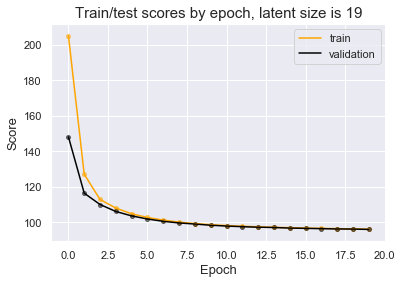

epoch: 0   score: 205.08 | val score: 148.19
epoch: 1   score: 127.12 | val score: 116.49
epoch: 2   score: 112.95 | val score: 110.12
epoch: 3   score: 108.1 | val score: 106.2
epoch: 4   score: 104.9 | val score: 103.72
epoch: 5   score: 102.81 | val score: 101.97
epoch: 6   score: 101.35 | val score: 100.67
epoch: 7   score: 100.21 | val score: 99.74
epoch: 8   score: 99.39 | val score: 99.14
epoch: 9   score: 98.77 | val score: 98.45
epoch: 10   score: 98.28 | val score: 98.01
epoch: 11   score: 97.89 | val score: 97.64
epoch: 12   score: 97.56 | val score: 97.36
epoch: 13   score: 97.29 | val score: 97.19
epoch: 14   score: 97.06 | val score: 96.87
epoch: 15   score: 96.86 | val score: 96.71
epoch: 16   score: 96.68 | val score: 96.54
epoch: 17   score: 96.54 | val score: 96.37
epoch: 18   score: 96.37 | val score: 96.3
epoch: 19   score: 96.24 | val score: 96.11


In [469]:
trained_model = train_conv(32*2, 20, 0.00095)

Как можно заметить, модель на основе сверточных слоев более хороший скор, лучше сходится и неподвержена переобучению спустя большое количество эпох.